In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import *
import operator
from tqdm import tqdm
import gseapy as gp
from core_functions import *
from statsmodels.stats.multitest import multipletests

plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

data_path = '../../data/'
SCdata_path = '../../tmp/scRNAseqdata/'

### Select the tumor cohort to perform the analyses on 

In [2]:
cohort = dropdown_dataset()
display(cohort)

Dropdown(description='Cohort:', options=('tumor+csf', 'tumor'), value='tumor+csf')

Data files loaded have been generated in scRNAseq_tumorIntegrated.R (tumor) or in scRNAseq_tumorCSFIntegrated.R (tumor+CSF)

In [3]:
data_filenames = {'tumor':'allTUMORintegrated','tumor+csf':'allTUMORCSFintegrated'}

### Select the cell subset to work on: all cells pooled together (all), Tcell+NK cells (TcellNK) or proliferating leukocytes (PROLIF)

In [4]:
subset = dropdown_subset()
display(subset)

Dropdown(description='Cell subset:', index=1, options=('all', 'TcellNK', 'PROLIF'), value='TcellNK')

# Load data

In [23]:
if cohort.value == 'tumor':
    SC = pd.read_excel(data_path+'Extended data 1.xlsx',sheet_name='g')
else:
    SC = pd.read_excel(data_path+'Extended data 1.xlsx',sheet_name='h')

In [24]:
raw_exp = pd.read_csv(SCdata_path+data_filenames[cohort.value]+'_'+subset.value+'_UMI.tsv',sep='\t').rename(columns={'Unnamed: 0':'GENE'}).T
cell_annot = SC[SC['Cell clustering group']==subset.value]
clusters_cells = {cluster:clusterdf['Cell ID'].tolist()  for cluster,clusterdf in cell_annot.groupby('cluster_cell_class')}
alltumor_markers = pd.read_csv(SCdata_path+data_filenames[cohort.value]+'_'+subset.value+'_allTumorMarkers.tsv',sep='\t')

# pre-ranked GSEA of immune population gene sets from the literature

In [25]:
allresults = pd.DataFrame()
cluster_lgp = alltumor_markers['cluster'].unique().tolist()
for cluster in tqdm(cluster_lgp):
    clusterdf = alltumor_markers[alltumor_markers['cluster']==cluster]
    tumor_markers_s = clusterdf[['gene','avg_logFC']].sort_values(by='avg_logFC',ascending=False).reset_index()
    if subset.value in ['all','TcellNK']:
        subsetgmt = subset.value
    else:
        subsetgmt = 'all'
    pre_res = gp.prerank(rnk=tumor_markers_s[['gene','avg_logFC']],
                         gene_sets=data_path+'LITERATURE_immune_genesets_'+subsetgmt+'.gmt',
                         outdir='../../tmp/', format='png', graph_num=5,
                         permutation_num=1000,
                         weighted_score_type=0, 
                         min_size=0, max_size=10000)
    results = pd.DataFrame(pre_res.res2d)
    results = results.reset_index()
    results['cluster'] = cluster
    allresults = allresults.append(results)

  0%|          | 0/5 [00:00<?, ?it/s]/home/carlota/anaconda3/lib/python3.7/site-packages/gseapy/algorithm.py:73: RuntimeWarning: divide by zero encountered in true_divide
  norm_tag =  1.0/sum_correl_tag
/home/carlota/anaconda3/lib/python3.7/site-packages/gseapy/algorithm.py:76: RuntimeWarning: invalid value encountered in multiply
  RES = np.cumsum(tag_indicator * correl_vector * norm_tag - no_tag_indicator * norm_no_tag, axis=axis)
/home/carlota/anaconda3/lib/python3.7/site-packages/gseapy/algorithm.py:83: RuntimeWarning: invalid value encountered in greater
  es_vec = np.where(np.abs(max_ES) > np.abs(min_ES), max_ES, min_ES)
100%|██████████| 5/5 [00:27<00:00,  5.47s/it]


In [26]:
def genheatmap_gsea(allresults_sig):
    geneset_GSEA = {}
    if len(allresults_sig)>0:
        allterms = allresults_sig['Term'].unique()
        for cluster in alltumor_markers.cluster.unique():
            vals = []
            for term in allterms:
                termdf = allresults_sig[allresults_sig['Term']==term]  
                if cluster in termdf['cluster'].tolist():
                    vals.append(termdf[termdf['cluster']==cluster]['nes'].values[0])
                else:
                    vals.append(0)
            geneset_GSEA[cluster] = vals

        geneset_GSEAdf = pd.DataFrame(geneset_GSEA)
        fig,ax = plt.subplots(figsize=(6,7))
        sns.heatmap(geneset_GSEAdf,cmap="Purples",yticklabels=allterms,vmax=max(geneset_GSEAdf),vmin=0.1)
        plt.title('GSEA DEgenes immune pop')
        plt.tight_layout()
        plt.show()
    return

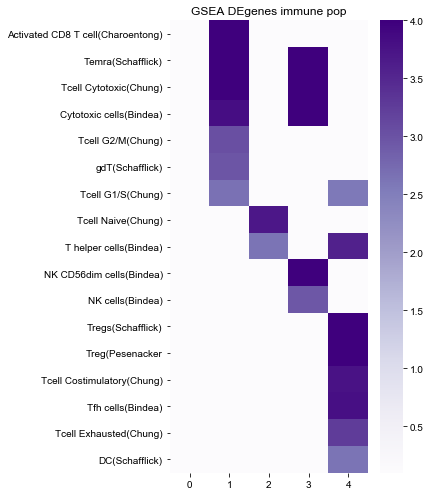

In [27]:
# Plot heatmap with GSEA results
allresults_sig = allresults[allresults['fdr']<0.25] #significant from < 0.25 according to documentation
allresults_sig = allresults_sig[allresults_sig['nes']>0] #keep only over-enrichments
if len(allresults_sig)>0:
    genheatmap_gsea(allresults_sig)
else:
    print('Any GSEA significant (fdr < 0.25 and nes >0)')  
    print('..trying filtering results by p-value < 0.05 and nes > 0')
    
    allresults_sig = allresults[allresults['pval']<0.05] 
    allresults_sig = allresults_sig[allresults_sig['nes']>0]
    
    if len(allresults_sig) > 0:
        genheatmap_gsea(allresults_sig)
    else:
        print('Any GSEA significant!!')

# Dot plot of manually curated gene markers

In [12]:
markersdata = pd.read_csv(data_path+'reference_markers.tsv',sep='\t',index_col=False)
markers = {subset:subsetdf.marker.tolist() for subset,subsetdf in markersdata.groupby('subset_name')}
markers_label = {subset:subsetdf.fillna('').cell_type_plot.tolist() for subset,subsetdf in markersdata.groupby('subset_name')}

In [13]:
subsetmarkers_mapping = {'all':list(markers.keys()),'TcellNK':['TcellNK'],'PROLIF':list(markers.keys())}

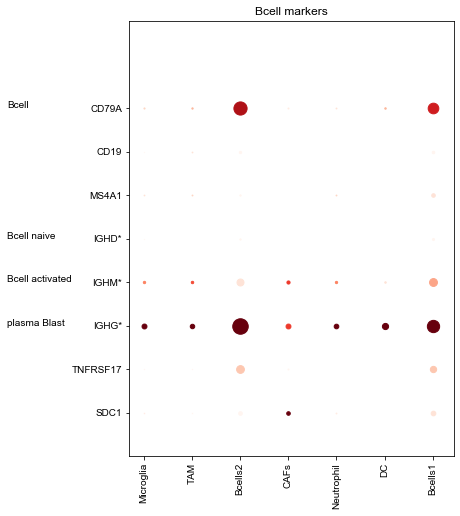

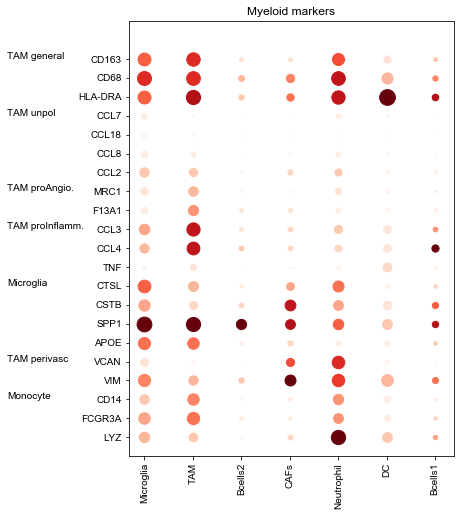

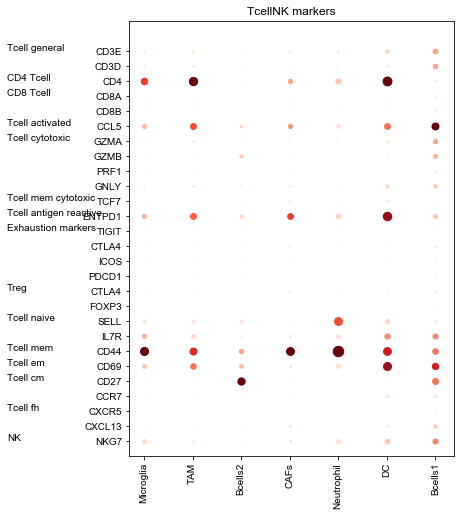

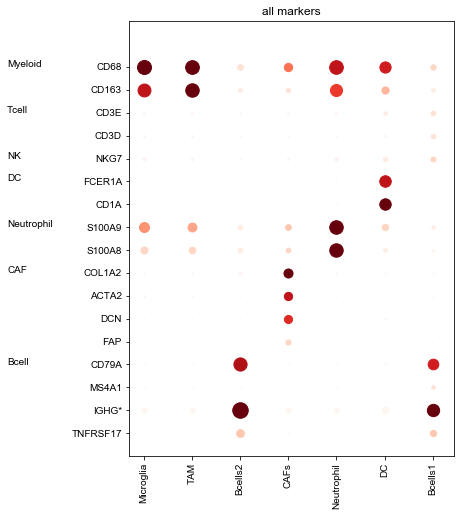

In [14]:
clusters_l = cell_annot.cluster_cell_class.unique()
for subset_study in subsetmarkers_mapping[subset.value]:
    markers_of_interest = markers[subset_study][::-1]
    markers_of_interest_labels = markers_label[subset_study][::-1]
    marksprop = []
    marksexp = []
    exp_cutoff = 1
    for c in clusters_l:
        raw_expT_c = raw_exp[raw_exp.index.isin(clusters_cells[c])]
        exp_cutoff = 0
        pos = {}
        expm = {}
        for marker in markers_of_interest:
            if marker[-1] == '*':
                genes_multiple = [c for c in raw_expT_c.columns if c.startswith(marker[:-1])]
                expmultiple = raw_expT_c[genes_multiple]
                prop_posdf = pd.DataFrame(expmultiple.mean(axis=1)>exp_cutoff,columns=[marker])
                prop_pos = len(prop_posdf[prop_posdf[marker]==True])/float(len(raw_expT_c))
                mean_exp = np.mean(pd.DataFrame(expmultiple.mean(axis=1))).values[0]
            else:    
                prop_posdf = pd.DataFrame(raw_expT_c[marker]>exp_cutoff)
                prop_pos = len(prop_posdf[prop_posdf[marker]==True])/float(len(raw_expT_c))
                mean_exp = np.mean(raw_expT_c[marker])
            pos[marker] = prop_pos
            expm[marker] = mean_exp
        marksprop.append(pos)
        marksexp.append(expm)
    markspropdf = pd.DataFrame(marksprop).T.reindex(markers_of_interest)
    marksexpdf = pd.DataFrame(marksexp).T.reindex(markers_of_interest)

    allexpvals = np.ravel(marksexpdf.values)
    

    allgreens = cm.get_cmap('Reds', len(allexpvals))
    allgreensl = [allgreens(i) for i in range(allgreens.N)]
    allexpvals_s = sorted(set(allexpvals))
    allexpvals_d = {v:i for i,v in enumerate(allexpvals_s)}

    fig,ax = plt.subplots(figsize=(8,8),ncols=2,gridspec_kw={'width_ratios': [1, 4]})
    for c in marksexpdf.columns:
        ser = marksexpdf[c]
        colz = get_color(ser, lo=None, hi=None)
        n = 0
        for row in markspropdf.to_dict(orient='records'):
            expv = marksexpdf[marksexpdf.index ==markers_of_interest[n]][c].values[0]
            if expv > 0:
                ax[1].scatter(c,n,s=250*row[c],c=colz[n])
            n+=1
    
    plt.sca(ax[1])
    plt.xticks(range(0,len(clusters_l)),clusters_l,rotation=90)
    plt.yticks(range(0,len(markers_of_interest)),markers_of_interest)
    plt.ylim(-1,len(markers_of_interest)+1)
    plt.title(subset_study+' markers')

    plt.sca(ax[0])
    plt.ylim(-1,len(markers_of_interest)+1)
    for i in range(0,len(markers_of_interest)):
        plt.text(0,i,markers_of_interest_labels[i])
        plt.text(1,i,'')
        plt.text(2,i,'')
        plt.text(3,i,'')
    plt.axis('off')
    plt.savefig(subset_study+'.svg')
    plt.show()

# Detailed analyses for certain cell types

In [5]:
raw_exp_all_tumor = pd.read_csv(SCdata_path+'allTUMORintegrated_all_normcounts.tsv',sep='\t').rename(columns={'Unnamed: 0':'GENE'})

### DE analysis between microglia and TAM clusters

In [18]:
cell_cluster_annotations = pd.read_excel(data_path+'Extended data 1.xlsx',sheet_name='g')
cells_cluster_annotations_selection = cell_cluster_annotations[(cell_cluster_annotations['Cell clustering group']=='all')
                                                               &(cell_cluster_annotations['cluster_cell_class'].isin(['TAM','Microglia']))]
clusters_cells = {cluster:clusterdf['Cell ID'].tolist()  for cluster,clusterdf in cells_cluster_annotations_selection.groupby('cluster_cell_class')}

In [19]:
sel_cols = cells_cluster_annotations_selection['Cell ID'].tolist()
cell_exp_sel = raw_exp_all_tumor[sel_cols].reset_index()
clusters_interest = list(clusters_cells.keys())
total_cels = {k:len(v) for k,v in clusters_cells.items()}
print(total_cels,len(cell_exp_sel))

{'Microglia': 3389, 'TAM': 4646} 33538


In [20]:
totals_l = [v*1000 for v in range(0,34)]
totals_l.append(33538)

In [21]:
import tqdm as tqmdm
DE = []

for v in totals_l:
    print('>>>',int(v),int(v)+1000)
    for row in tqdm(cell_exp_sel[v:v+1000].to_dict(orient='records')):
        x = [row[c] for c in clusters_cells['TAM']]
        y = [row[c] for c in clusters_cells['Microglia']]
        try:
            U, pval = mannwhitneyu(x, y)
        except:
            continue
        DE.append({'GENE':row['index'], 'PVAL':pval, 'FC':np.mean(x)/float(np.mean(y))})
DEdf = pd.DataFrame(DE)
DEdfs = DEdf[~DEdf['FC'].isin([np.inf, -np.inf])]

>>> 0 1000


  0%|          | 0/1000 [00:00<?, ?it/s]/home/carlota/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
100%|██████████| 1000/1000 [00:02<00:00, 357.28it/s]


>>> 1000 2000


100%|██████████| 1000/1000 [00:02<00:00, 398.06it/s]


>>> 2000 3000


100%|██████████| 1000/1000 [00:03<00:00, 307.92it/s]


>>> 3000 4000


100%|██████████| 1000/1000 [00:02<00:00, 488.45it/s]


>>> 4000 5000


100%|██████████| 1000/1000 [00:03<00:00, 283.55it/s]


>>> 5000 6000


100%|██████████| 1000/1000 [00:03<00:00, 266.53it/s]


>>> 6000 7000


100%|██████████| 1000/1000 [00:03<00:00, 311.73it/s]


>>> 7000 8000


100%|██████████| 1000/1000 [00:03<00:00, 302.01it/s]


>>> 8000 9000


100%|██████████| 1000/1000 [00:03<00:00, 285.25it/s]


>>> 9000 10000


100%|██████████| 1000/1000 [00:04<00:00, 205.66it/s]


>>> 10000 11000


100%|██████████| 1000/1000 [00:03<00:00, 302.97it/s]


>>> 11000 12000


100%|██████████| 1000/1000 [00:02<00:00, 369.02it/s]


>>> 12000 13000


100%|██████████| 1000/1000 [00:02<00:00, 352.29it/s]


>>> 13000 14000


100%|██████████| 1000/1000 [00:02<00:00, 336.53it/s]


>>> 14000 15000


100%|██████████| 1000/1000 [00:04<00:00, 248.52it/s]


>>> 15000 16000


100%|██████████| 1000/1000 [00:02<00:00, 367.99it/s]


>>> 16000 17000


100%|██████████| 1000/1000 [00:02<00:00, 361.30it/s]


>>> 17000 18000


100%|██████████| 1000/1000 [00:02<00:00, 434.07it/s]


>>> 18000 19000


100%|██████████| 1000/1000 [00:03<00:00, 293.14it/s]


>>> 19000 20000


100%|██████████| 1000/1000 [00:02<00:00, 393.39it/s]


>>> 20000 21000


100%|██████████| 1000/1000 [00:02<00:00, 370.70it/s]


>>> 21000 22000


100%|██████████| 1000/1000 [00:02<00:00, 451.01it/s]


>>> 22000 23000


100%|██████████| 1000/1000 [00:02<00:00, 416.30it/s]


>>> 23000 24000


100%|██████████| 1000/1000 [00:02<00:00, 361.42it/s]


>>> 24000 25000


100%|██████████| 1000/1000 [00:02<00:00, 354.59it/s]


>>> 25000 26000


100%|██████████| 1000/1000 [00:02<00:00, 389.58it/s]


>>> 26000 27000


100%|██████████| 1000/1000 [00:02<00:00, 357.34it/s]


>>> 27000 28000


100%|██████████| 1000/1000 [00:02<00:00, 401.67it/s]


>>> 28000 29000


100%|██████████| 1000/1000 [00:02<00:00, 413.16it/s]


>>> 29000 30000


100%|██████████| 1000/1000 [00:02<00:00, 398.83it/s]


>>> 30000 31000


100%|██████████| 1000/1000 [00:02<00:00, 361.09it/s]


>>> 31000 32000


100%|██████████| 1000/1000 [00:02<00:00, 365.66it/s]


>>> 32000 33000


100%|██████████| 1000/1000 [00:02<00:00, 436.17it/s]


>>> 33000 34000


100%|██████████| 538/538 [00:01<00:00, 374.63it/s]


>>> 33538 34538


0it [00:00, ?it/s]


In [30]:
pre_res = gp.prerank(rnk=DEdfs[['GENE','FC']].sort_values(by='FC',ascending=False),
                     gene_sets=data_path+'LITERATURE_immune_genesets_TAM.gmt',
                     outdir='../../tmp/', format='svg', graph_num=5,
                     permutation_num=1000,
                     weighted_score_type=0, 
                     min_size=0, max_size=10000)

In [22]:
import tqdm as tqmdm
DE = []

for v in totals_l:
    print('>>>',int(v),int(v)+1000)
    for row in tqdm(cell_exp_sel[v:v+1000].to_dict(orient='records')):
        x = [np.log2(row[c]+1) for c in clusters_cells['TAM']]
        y = [np.log2(row[c]+1) for c in clusters_cells['Microglia']]
        try:
            U, pval = mannwhitneyu(x, y)
        except:
            continue
        DE.append({'GENE':row['index'], 'PVAL':pval, 'logFC':np.mean(y)-float(np.mean(x))})
DEdf = pd.DataFrame(DE)
DEdfs = DEdf[~DEdf['logFC'].isin([np.inf, -np.inf])]
DEdfs['QVALUE'] = multipletests(DEdfs['PVAL'],method='fdr_bh')[1]
DEdfs['QVALUElog'] = DEdfs['QVALUE'].apply(lambda x: -1*np.log10(x))

>>> 0 1000


100%|██████████| 1000/1000 [00:12<00:00, 82.54it/s]


>>> 1000 2000


100%|██████████| 1000/1000 [00:10<00:00, 93.89it/s]


>>> 2000 3000


100%|██████████| 1000/1000 [00:10<00:00, 96.91it/s]


>>> 3000 4000


100%|██████████| 1000/1000 [00:10<00:00, 95.85it/s]


>>> 4000 5000


100%|██████████| 1000/1000 [00:10<00:00, 95.23it/s]


>>> 5000 6000


100%|██████████| 1000/1000 [00:11<00:00, 84.64it/s]


>>> 6000 7000


100%|██████████| 1000/1000 [00:10<00:00, 95.60it/s]


>>> 7000 8000


100%|██████████| 1000/1000 [00:09<00:00, 101.97it/s]


>>> 8000 9000


100%|██████████| 1000/1000 [00:09<00:00, 102.98it/s]


>>> 9000 10000


100%|██████████| 1000/1000 [00:09<00:00, 101.92it/s]


>>> 10000 11000


100%|██████████| 1000/1000 [00:09<00:00, 100.74it/s]


>>> 11000 12000


100%|██████████| 1000/1000 [00:11<00:00, 87.13it/s]


>>> 12000 13000


100%|██████████| 1000/1000 [00:12<00:00, 79.46it/s]


>>> 13000 14000


100%|██████████| 1000/1000 [00:11<00:00, 88.44it/s]


>>> 14000 15000


100%|██████████| 1000/1000 [00:23<00:00, 41.68it/s]


>>> 15000 16000


100%|██████████| 1000/1000 [00:12<00:00, 82.96it/s]


>>> 16000 17000


100%|██████████| 1000/1000 [00:14<00:00, 67.65it/s]


>>> 17000 18000


100%|██████████| 1000/1000 [00:14<00:00, 68.09it/s]


>>> 18000 19000


100%|██████████| 1000/1000 [00:13<00:00, 72.05it/s]


>>> 19000 20000


100%|██████████| 1000/1000 [00:11<00:00, 87.77it/s]


>>> 20000 21000


100%|██████████| 1000/1000 [00:09<00:00, 101.89it/s]


>>> 21000 22000


100%|██████████| 1000/1000 [00:09<00:00, 108.26it/s]


>>> 22000 23000


100%|██████████| 1000/1000 [00:12<00:00, 77.83it/s]


>>> 23000 24000


100%|██████████| 1000/1000 [00:13<00:00, 76.21it/s]


>>> 24000 25000


100%|██████████| 1000/1000 [00:13<00:00, 76.25it/s]


>>> 25000 26000


100%|██████████| 1000/1000 [00:11<00:00, 90.51it/s]


>>> 26000 27000


100%|██████████| 1000/1000 [00:13<00:00, 74.64it/s]


>>> 27000 28000


100%|██████████| 1000/1000 [00:11<00:00, 88.72it/s]


>>> 28000 29000


100%|██████████| 1000/1000 [00:11<00:00, 87.68it/s]


>>> 29000 30000


100%|██████████| 1000/1000 [00:12<00:00, 78.44it/s]


>>> 30000 31000


100%|██████████| 1000/1000 [00:11<00:00, 89.80it/s]


>>> 31000 32000


100%|██████████| 1000/1000 [00:12<00:00, 81.06it/s]


>>> 32000 33000


100%|██████████| 1000/1000 [00:16<00:00, 62.02it/s]


>>> 33000 34000


100%|██████████| 538/538 [00:07<00:00, 70.74it/s]


>>> 33538 34538


0it [00:00, ?it/s]


In [36]:
def make_volcano(celltype_res, mark, val_x, val_y, element, pval_logthr,
                 savefig_name,genes_l,sz):    
    fig, axes = plt.subplots(figsize=(5,5))
    celltype_res_s = celltype_res[celltype_res[val_y] > pval_logthr]
    celltype_res_ns = celltype_res[celltype_res[val_y] <= pval_logthr]
    if len(celltype_res_s) > 0:
        celltype_res_es = celltype_res_s[celltype_res_s[val_x]>0]
        if len(celltype_res_es) > 0:        
            for row in celltype_res_es.to_dict(orient='records'):
                plt.scatter(row[val_x], row[val_y],s=sz, marker=mark, 
                            color='#00d451',
                            alpha=0.4)  
        celltype_res_es_down = celltype_res_s[celltype_res_s[val_x]<0]
        if len(celltype_res_es_down) > 0:        
            for row in celltype_res_es_down.to_dict(orient='records'):               
                plt.scatter(row[val_x], row[val_y],s=sz, 
                            marker=mark, color='#79ff12',
                            alpha=0.4)  
    if len(celltype_res_ns) > 0:
        plt.scatter(celltype_res_ns[val_x].tolist(),
                      celltype_res_ns[val_y].tolist(),
                    s=sz, marker=mark, color='grey', alpha=0.4) 
    for row in celltype_res.to_dict(orient='records'):
        gene = str(row[element].upper().replace(' ',''))
        if gene in genes_l:
            plt.text(row[val_x], row[val_y], gene,
                     fontsize=10)
            plt.scatter(row[val_x], row[val_y],s=sz, marker=mark, 
                        facecolors='none', edgecolors='black')
    plt.ylabel('-log10 adjusted P-value')
    plt.xlabel('log2 Fold Change')
    plt.hlines(y=pval_logthr, xmin=-5, xmax=7, linestyles='--',linewidth=0.6)
    plt.xlim(-2,2)
    
    plt.grid()
    plt.show()
    return

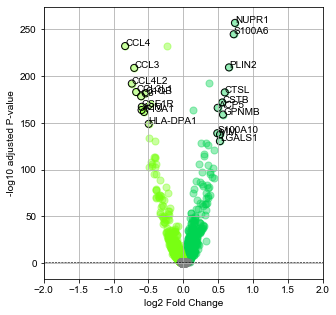

In [37]:
genes_of_interest = DEdfs.sort_values(by='FC',ascending=False)['GENE'].tolist()[:10]
genes_of_interest.extend(DEdfs.sort_values(by='FC',ascending=True)['GENE'].tolist()[:10])
make_volcano(DEdfs, 'o', 'logFC', 'QVALUElog', 'GENE', 1.3,'',genes_of_interest,50)

### CD4 highlight in TcellNK subset

In [9]:
cells_cluster_annotations_selection = SC[SC['Cell clustering group']=='TcellNK']
clusters_cells = {cluster:clusterdf['Cell ID'].tolist()  for cluster,clusterdf in cells_cluster_annotations_selection.groupby('cluster_cell_class')}

In [10]:
sel_cols = cells_cluster_annotations_selection['Cell ID'].tolist()
cell_exp_sel = raw_exp_all_tumor[sel_cols].reset_index()
clusters_interest = list(clusters_cells.keys())
total_cels = {k:len(v) for k,v in clusters_cells.items()}
print(total_cels,len(cell_exp_sel))

{'Cyt cells [>>NK]': 380, 'Cyt cells [>>Tcell]': 784, 'Cyt cells [Tcell+NK]': 986, 'Naive Tcells': 517, 'Treg': 294} 33538


In [11]:
cell_exp_selCD4 = cell_exp_sel[cell_exp_sel['index']=='CD4']

In [12]:
cluster_exp = {cluster: cell_exp_selCD4[cells].values.tolist()[0] for cluster,cells in clusters_cells.items() }

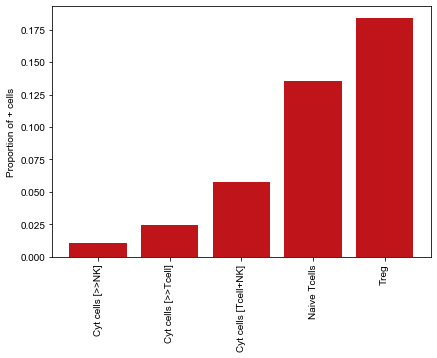

In [17]:
x = 0
xlabels = []
for cluster,vals in cluster_exp.items():
    if ncol > 2:
        ncol = 0
        nrow+=1
    
    percells = len([v for v in vals if v > 0])/float(len(vals))
    
    plt.bar(x,percells,color='#bf151a')
    xlabels.append(cluster)
    x+=1
plt.tight_layout()
plt.xticks(range(0,len(xlabels)),xlabels,rotation=90)
plt.ylabel('Proportion of + cells')
plt.show()